# Purpose

Let's just poke around and get some descriptive stats on the dataset.

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join, getsize
import json
import itertools
import seaborn as sns
import librosa
from joblib import Parallel, delayed
import subprocess

np.random.seed(37)
sns.set_style('whitegrid')

In [2]:
def get_state_mapping():
    with open('states.json', 'rb') as f:
        return json.load(f)
    
def get_codes_states_mapping():
    d = {}
    with open('codes-states.txt') as f:
        for line in f:
            tokens = [t.strip().lower() for t in line.split(',')]
            d[tokens[0]] = tokens[1]
    return d

def get_states():
    d = []
    with open('states.txt') as f:
        for line in f:
            d.append(line.strip().lower())
    return d
    
def load_json(fname):
    with open(fname, 'rb') as f:
        return json.load(f)['recordings']

def get_state(loc):
    state = loc.lower().strip()
    
    comma_index = loc.rfind(',')
    if comma_index > 0:
        state = loc[comma_index + 1:len(loc)].strip().lower()

    if state in valid_states:
        return state
    
    if state in codes_states_mapping:
        state = codes_states_mapping[state]
        return state

    return None
  
def get_lat_lng(v):
    if v is not None and len(v.strip()) > 0:
        try:
            return float(v)
        except:
            pass
    return None
    
def get_recording(data):
    mp3 = './mp3/{}.mp3'.format(data['id'])
    return {
        'id': data['id'],
        'state': get_state(data['loc']),
        'en': data['en'].strip().lower(),
        'sp': data['sp'].strip().lower(),
        'ssp': data['ssp'].strip().lower(),
        'gen': data['gen'].strip().lower(),
        'lat': get_lat_lng(data['lat']),
        'lng': get_lat_lng(data['lng']),
        'types': [t.strip().lower() for t in data['type'].split(',')],
        'mp3': mp3,
        'mp3_size': getsize(mp3),
        'duration': 0.0
    }

def get_recording_duration(idx, data, use_librosa=False):
    duration = None
    fname = data['mp3']
    
    if use_librosa is True:
        y, sr = librosa.load(data['mp3'])
        duration = librosa.core.get_duration(y=y, sr=sr)
    else:
        args=('ffprobe', '-show_entries', 'format=duration', '-i', data['mp3'])
        popen = subprocess.Popen(args, stdout = subprocess.PIPE)
        popen.wait()
        output = popen.stdout.read()
        try:
            duration = float(output.split('\n')[1].split('=')[1])
        except:
            pass
    return idx, duration

def convert_rdict_to_df(data):
    def to_tuple(d):
        t = (d['id'], d['state'], d['en'], d['sp'], d['ssp'], d['gen'], d['lat'], d['lng'], d['types'], d['mp3'], d['mp3_size'], d['duration'])
        return t
    
    recordings = [to_tuple(d) for d in data]
    return pd.DataFrame(recordings, columns=['id', 'state', 'en', 'sp', 'ssp', 'gen', 'lat', 'lng', 'types', 'mp3', 'mp3_size', 'duration'])

def get_recording_data():
    raw_data = [load_json('./json/{}'.format(f)) for f in listdir('./json') if isfile(join('./json', f))]
    print('{} total json files'.format(len(raw_data)))

    raw_data = list(itertools.chain(*raw_data))
    print('{} total recordings from json'.format(len(raw_data)))

    data = [get_recording(item) for item in raw_data]
    print('{} total recordings items'.format(len(data)))

    return data

In [3]:
codes_states_mapping = get_codes_states_mapping()
valid_states = get_states()
recording_data = get_recording_data()

83 total json files
41291 total recordings from json
41291 total recordings items


In [4]:
results = Parallel(n_jobs=-1, verbose=5)(delayed(get_recording_duration)(i, data) for i, data in enumerate(recording_data))
for r in results:
    recording_data[r[0]]['duration'] = r[1]

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 3712 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 5116 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 6736 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 8572 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 10624 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 12892 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 15376 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 18076 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 20992 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 24124 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 27472 tasks      | elaps

In [5]:
print('{} total lengths'.format(len(results)))

41291 total lengths


In [6]:
recording_df = convert_rdict_to_df(recording_data)

In [7]:
recording_df.query('duration > 0').head(5)

,id,state,en,sp,ssp,gen,lat,lng,types,mp3,mp3_size,duration
0,135670,tennessee,red-headed woodpecker,erythrocephalus,,melanerpes,35.386,-84.125,[song],./mp3/135670.mp3,296091,18.249688
1,109610,tennessee,red-headed woodpecker,erythrocephalus,,melanerpes,35.386,-84.125,"[begging call, call, juvenile]",./mp3/109610.mp3,1261252,78.572250
2,109609,tennessee,red-headed woodpecker,erythrocephalus,,melanerpes,35.386,-84.125,[call],./mp3/109609.mp3,388080,23.999000
3,109608,tennessee,red-headed woodpecker,erythrocephalus,,melanerpes,35.386,-84.125,[call],./mp3/109608.mp3,452863,28.047938
4,105601,None,red-headed woodpecker,erythrocephalus,,melanerpes,38.140,-98.479,[call],./mp3/105601.mp3,690469,42.945306


In [8]:
recording_df.to_csv('recording.csv', header=True, index=False)

# Visualize some distributions

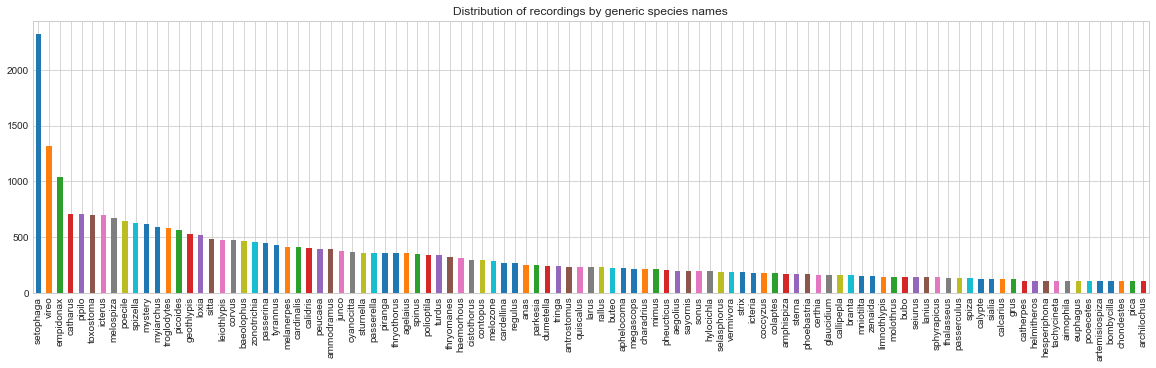

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.set_title('Distribution of recordings by generic species names')
s = recording_df['gen'].value_counts()
s = s[s > 100]
s.plot(kind='bar', ax=ax)

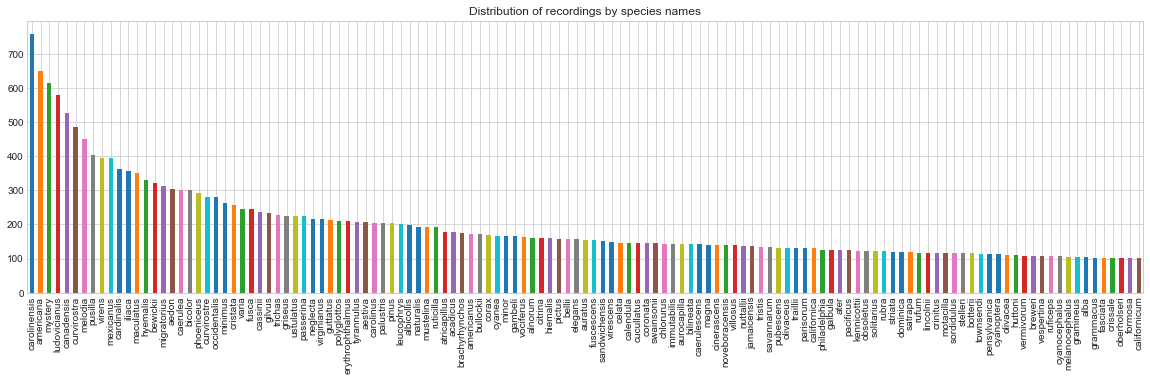

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.set_title('Distribution of recordings by species names')
s = recording_df['sp'].value_counts()
s = s[s > 100]
s.plot(kind='bar', ax=ax)

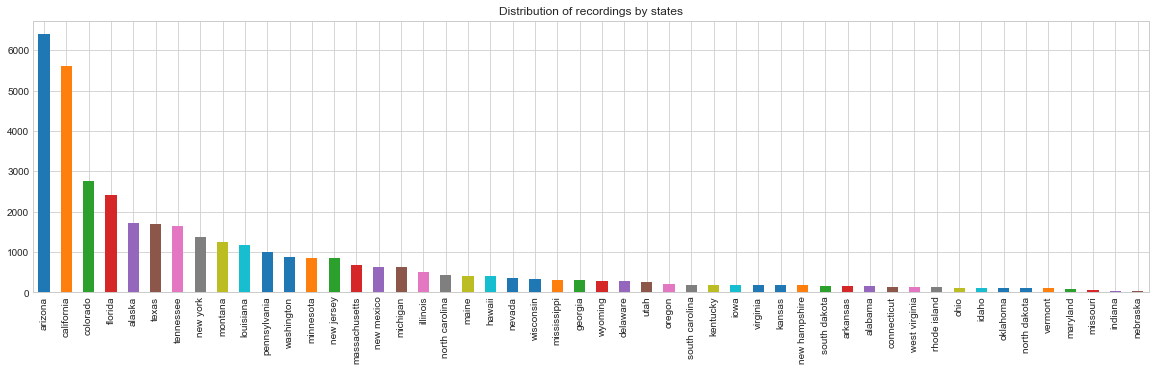

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.set_title('Distribution of recordings by states')
s = recording_df['state'].value_counts()
s.plot(kind='bar', ax=ax)

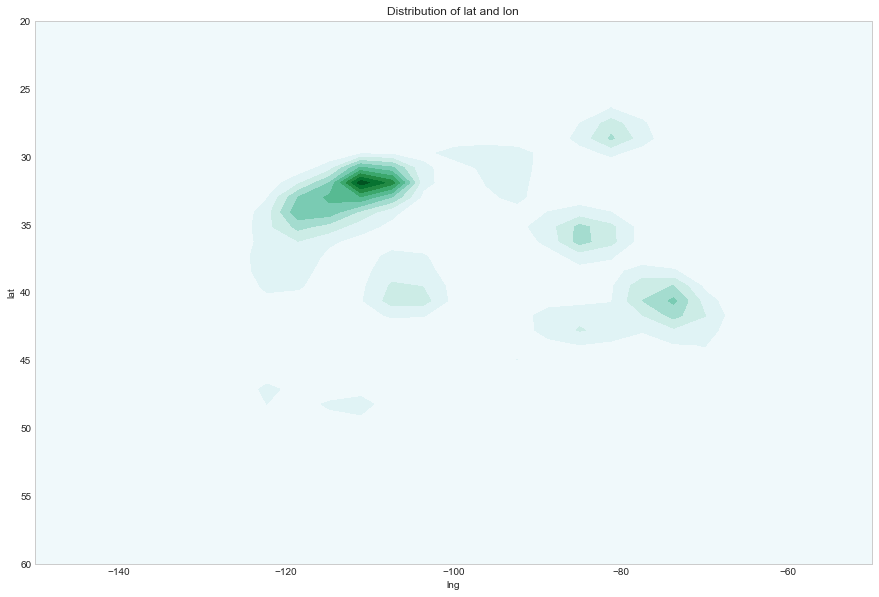

In [12]:
df = recording_df[np.isfinite(recording_df['lat']) & np.isfinite(recording_df['lng'])]
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.set_xlim([-150, -50])
ax.set_ylim([60, 20])
ax.set_title('Distribution of lat and lon')
sns.kdeplot(df['lng'], df['lat'], shade=True)

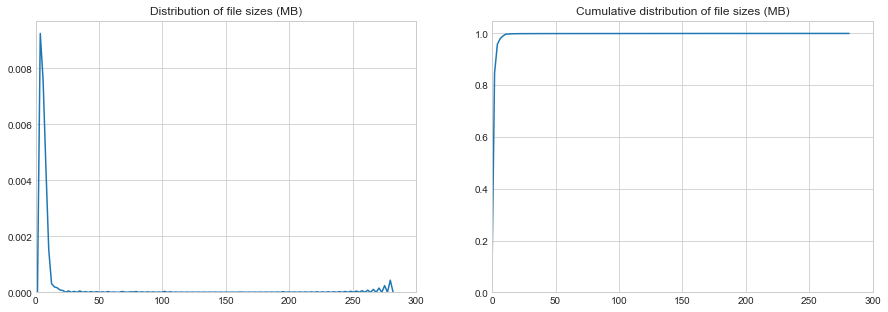

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('Distribution of file sizes (MB)')
ax[1].set_title('Cumulative distribution of file sizes (MB)')
ax[0].set_xlim([0, 300])
ax[1].set_xlim([0, 300])
s = recording_df['mp3_size'] / float(1024*1024)
sns.kdeplot(s, bw=0.25, ax=ax[0], label='mp3 file size')
sns.kdeplot(s, cumulative=True, ax=ax[1], label='mp3 file size')
ax[0].legend_.remove()
ax[1].legend_.remove()

About 87% of the data is less than 2 MB in size.

In [18]:
hist, bin_edges = np.histogram(s, bins=2000, normed=False)
cum = np.cumsum(hist)
for e, c in zip(bin_edges, cum):
    print('{:.5f}, {:.5f}, {}, {:.5f}'.format(e, e / 60.0, c, c / float(len(recording_data))))
    if e > 2.0:
        break

0.00024, 0.00000, 4675, 0.11322
0.14083, 0.00235, 10408, 0.25206
0.28142, 0.00469, 15275, 0.36994
0.42201, 0.00703, 19197, 0.46492
0.56259, 0.00938, 22393, 0.54232
0.70318, 0.01172, 25074, 0.60725
0.84377, 0.01406, 27460, 0.66504
0.98436, 0.01641, 29170, 0.70645
1.12495, 0.01875, 30625, 0.74169
1.26554, 0.02109, 31822, 0.77068
1.40612, 0.02344, 32840, 0.79533
1.54671, 0.02578, 33723, 0.81672
1.68730, 0.02812, 34476, 0.83495
1.82789, 0.03046, 35193, 0.85232
1.96848, 0.03281, 35769, 0.86627
2.10907, 0.03515, 36258, 0.87811


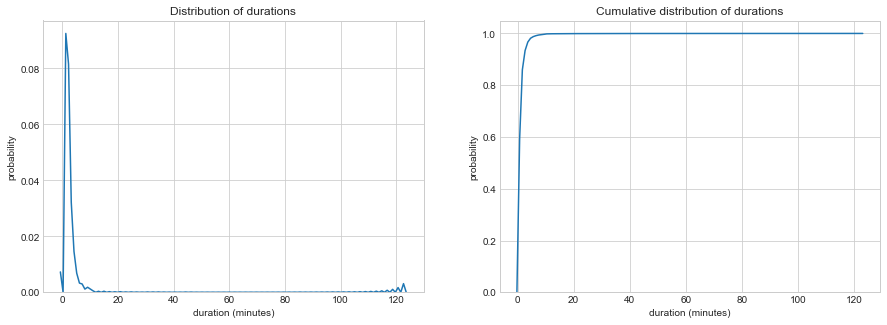

In [14]:
df = recording_df[np.isfinite(recording_df['duration'])]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Distribution of durations')
ax[1].set_title('Cumulative distribution of durations')
ax[0].set_xlabel('duration (minutes)')
ax[1].set_xlabel('duration (minutes)')
ax[0].set_ylabel('probability')
ax[1].set_ylabel('probability')

s = df['duration'] / 60.0
sns.kdeplot(s, bw=0.25, ax=ax[0], label='duration')
sns.kdeplot(s, cumulative=True, ax=ax[1], label='duration')
ax[0].legend_.remove()
ax[1].legend_.remove()

About 73% of the data is less than a minute.

In [15]:
hist, bin_edges = np.histogram(s, bins=2000, normed=False)
cum = np.cumsum(hist)
for e, c in zip(bin_edges, cum):
    print('{:.5f}, {:.5f}, {}, {:.5f}'.format(e, e / 60.0, c, c / float(len(recording_data))))
    if e > 1.5:
        break

0.00392, 0.00007, 1418, 0.03434
0.06534, 0.00109, 4058, 0.09828
0.12676, 0.00211, 6737, 0.16316
0.18818, 0.00314, 9331, 0.22598
0.24960, 0.00416, 11915, 0.28856
0.31103, 0.00518, 14195, 0.34378
0.37245, 0.00621, 16339, 0.39570
0.43387, 0.00723, 18241, 0.44177
0.49529, 0.00825, 20123, 0.48735
0.55671, 0.00928, 21783, 0.52755
0.61813, 0.01030, 23235, 0.56271
0.67955, 0.01133, 24618, 0.59621
0.74097, 0.01235, 25840, 0.62580
0.80239, 0.01337, 26969, 0.65314
0.86381, 0.01440, 28010, 0.67836
0.92523, 0.01542, 29032, 0.70311
0.98665, 0.01644, 29965, 0.72570
1.04808, 0.01747, 30812, 0.74622
1.10950, 0.01849, 31534, 0.76370
1.17092, 0.01952, 32162, 0.77891
1.23234, 0.02054, 32722, 0.79247
1.29376, 0.02156, 33250, 0.80526
1.35518, 0.02259, 33692, 0.81596
1.41660, 0.02361, 34158, 0.82725
1.47802, 0.02463, 34546, 0.83665
1.53944, 0.02566, 34939, 0.84617


In [21]:
def flatten_types(df):
    sound_types = []
    for i, r in df.iterrows():
        sound_types.extend(r['types'])
    return pd.DataFrame(sound_types, columns=['types'])

In [25]:
s = flatten_types(recording_df)['types'].value_counts()

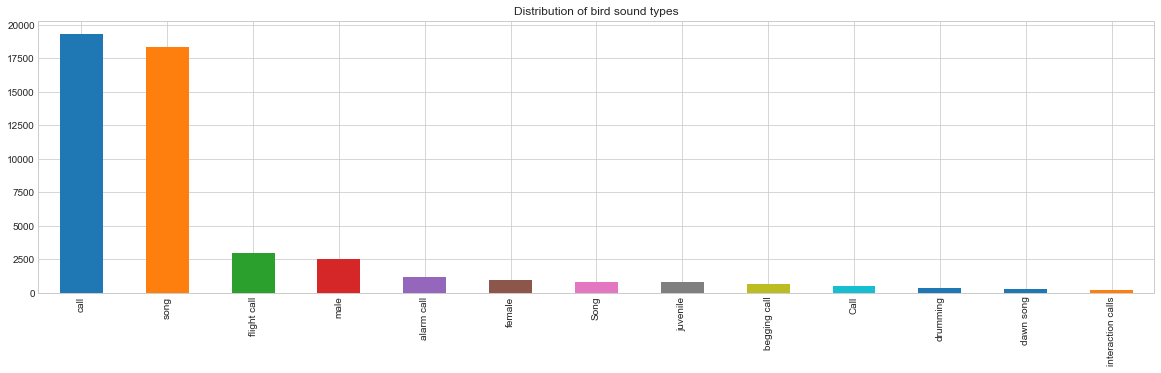

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.set_title('Distribution of bird sound types')
s = s[s > 100]
s.plot(kind='bar', ax=ax)

# Plot random samples

In [19]:
from scipy.fftpack import fft
 
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def plot_fft(y, t_n, ax):
    N = len(y)
    T = t_n / float(N)
    f_s = 1/T

    f_values, fft_values = get_fft_values(y, T, N, f_s)

    ax.plot(f_values, fft_values, linestyle='-', color='blue')
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('amplitude')
    ax.set_title("Frequency domain of the signal")
    
def sample_recording(n, df, max_size_mb=0.5):
    total = df.shape[0]
    samples = []
    while len(samples) < n:
        i = np.random.randint(0, total)
        if i in samples:
            pass
        r = df.loc[i]
        if r['mp3_size'] / float(1024 * 1024) <= max_size_mb:
            samples.append(i)
    return samples

0: ./mp3/359187.mp3 @ 0.187436103821
1: ./mp3/109449.mp3 @ 0.0499725341797
2: ./mp3/235106.mp3 @ 0.0683975219727
3: ./mp3/65306.mp3 @ 0.237760543823
4: ./mp3/111879.mp3 @ 0.218607902527
5: ./mp3/163177.mp3 @ 0.160999298096
6: ./mp3/253971.mp3 @ 0.404042243958
7: ./mp3/70973.mp3 @ 0.2257604599
8: ./mp3/163996.mp3 @ 0.0679798126221
9: ./mp3/277509.mp3 @ 0.214230537415


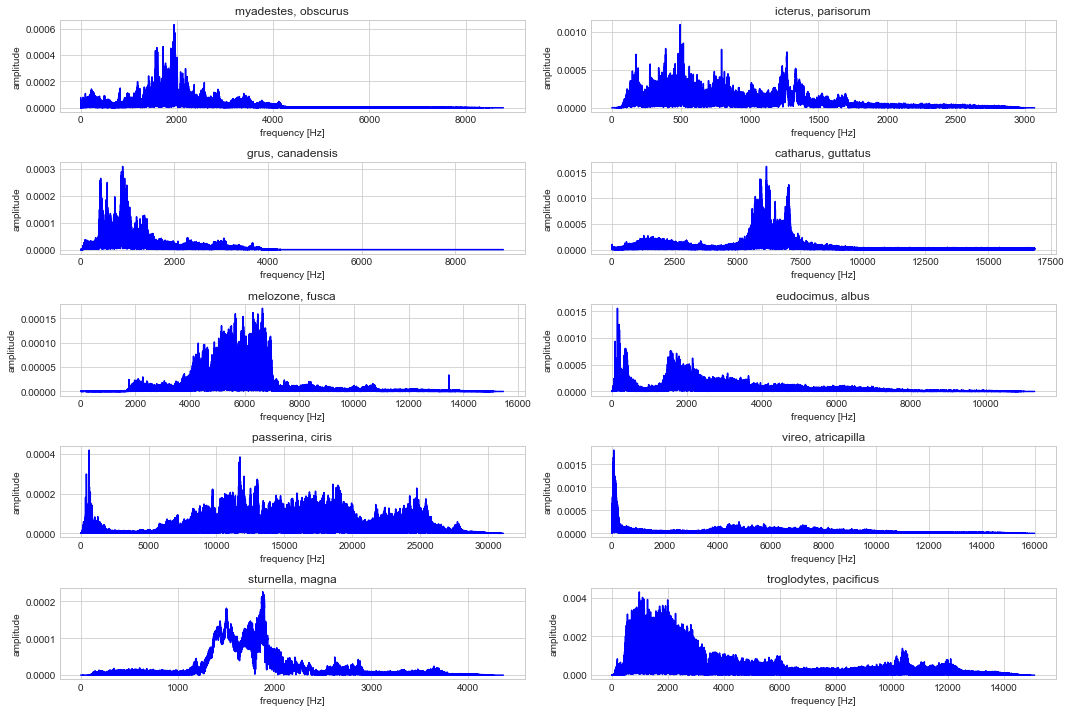

In [20]:
fig, ax = plt.subplots(5, 2, figsize=(15, 10), sharex=False, sharey=False)
samples = sample_recording(10, recording_df)
for i, axis in enumerate(np.ravel(ax)):
    r = recording_df.loc[samples[i]]
    fname = r['mp3']
    fsize = r['mp3_size'] / float(1024*1024)
    gen = r['gen']
    sp = r['sp']
    title = '{}, {}'.format(gen, sp)
    print('{}: {} @ {}'.format(i, fname, fsize))
    y, sr = librosa.load(fname)
    plot_fft(y, 10, axis)
    axis.set_title(title)
plt.tight_layout()

# References

* [Find the length of a mp3 file](https://stackoverflow.com/questions/6037826/finding-the-length-of-an-mp3-file)
* [can't run "delayed" from within a function](https://github.com/joblib/joblib/issues/114)
* [Python subprocess module](https://docs.python.org/2/library/subprocess.html#module-subprocess)
* [numpy histogram](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html)